In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
#from keras import layers, losses
from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout, Bidirectional
from sklearn.preprocessing import MinMaxScaler
import datetime
import requests
"""
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.layers.recurrent import LSTM
"""
import matplotlib.pyplot as plt
from plotly import express as px
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import preprocessing, tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [3]:
# NASA API
def get_nasa_power_data(lat, lon, start_date, end_date):
    """
    Fetches NASA POWER API data for given latitude, longitude, and time range.

    Args:
    - lat (float): Latitude of the location.
    - lon (float): Longitude of the location.
    - start_date (str): Start date in YYYYMMDD format.
    - end_date (str): End date in YYYYMMDD format.

    Returns:
    - Pandas DataFrame with selected weather parameters.
    """

    # Specify multiple parameters in the API request
    parameters = "PRECSNO,T2MDEW,PRECTOTCORR,T2M,WS2M,RH2M,CLOUD_AMT"

    url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params = {
        "parameters": parameters,
        "community": "RE",
        "longitude": lon,
        "latitude": lat,
        "start": start_date,
        "end": end_date,
        "format": "JSON"
    }

    response = requests.get(url, params=params)

    data = response.json()

    # Convert JSON response to DataFrame and transpose it
    nasa_weather = pd.DataFrame.from_dict(data["properties"]["parameter"], orient="index").T

    # Reset index and rename date column
    nasa_weather.reset_index(inplace=True)
    nasa_weather.rename(columns={"index": "date"}, inplace=True)

    # Convert date column to proper datetime format
    nasa_weather["date"] = pd.to_datetime(nasa_weather["date"], format="%Y%m%d", errors="coerce")
    nasa_weather.dropna(subset=["date"], inplace=True)  # Remove invalid date rows

    nasa_weather.rename(columns={
        "PRECSNO": "Snow_Precipitation",
        "T2MDEW": "Dew_Point_2m",
        "PRECTOTCORR": "Total_Precipitation_mm",
        "T2M": "Temperature_2m_C",
        "WS2M": "Wind_Speed_2m",
        # new cols
        "RH2M": "Relative_Humidity_2m_%",
        "CLOUD_AMT" : "Cloud_Amount_%",
    }, inplace=True)

    # Add Rounded_Lat and Rounded_Lng for merging
    nasa_weather['Rounded_Lat'] = lat
    nasa_weather['Rounded_Lng'] = lon

    # Display DataFrame
    # print(f"\n Weather Data for Latitude {lat}, Longitude {lon}\n")
    nasa_weather['Precipitation(in)'] = nasa_weather['Total_Precipitation_mm'] / 25.4 # mm to in
    nasa_weather['Temperature(F)'] = (nasa_weather['Temperature_2m_C'] * (9./5.)) + 32. # C to F
    nasa_weather['Wind_Speed(mph)'] = nasa_weather['Wind_Speed_2m'] * 2.237 # m/s to mph
    # nasa_weather.dropna()
    # display(nasa_weather)  # Works in Jupyter Notebook

    return nasa_weather

In [37]:
df_test = get_nasa_power_data(34.05, -118.25, "20240120", "20240201")
df_test

,date,Snow_Precipitation,Dew_Point_2m,Total_Precipitation_mm,Temperature_2m_C,Wind_Speed_2m,Relative_Humidity_2m_%,Cloud_Amount_%,Rounded_Lat,Rounded_Lng,Precipitation(in),Temperature(F),Wind_Speed(mph)
0,2024-01-20,0.0,11.98,10.28,12.50,2.21,96.42,98.29,34.05,-118.25,0.404724,54.500,4.94377
1,2024-01-21,0.0,10.52,3.64,12.55,1.51,88.78,83.99,34.05,-118.25,0.143307,54.590,3.37787
2,2024-01-22,0.0,11.85,20.82,12.82,2.72,94.16,89.45,34.05,-118.25,0.819685,55.076,6.08464
3,2024-01-23,0.0,9.06,0.29,12.66,2.23,81.79,32.63,34.05,-118.25,0.011417,54.788,4.98851
4,2024-01-24,0.0,9.95,0.24,11.77,1.37,89.55,81.43,34.05,-118.25,0.009449,53.186,3.06469
5,2024-01-25,0.0,8.47,0.75,12.56,1.65,80.67,29.79,34.05,-118.25,0.029528,54.608,3.69105
6,2024-01-26,0.0,3.63,0.00,13.31,2.17,59.40,56.49,34.05,-118.25,0.000000,55.958,4.85429
7,2024-01-27,0.0,3.35,0.00,15.82,1.96,47.01,54.07,34.05,-118.25,0.000000,60.476,4.38452
8,2024-01-28,0.0,6.00,0.00,17.02,1.79,51.47,75.61,34.05,-118.25,0.000000,62.636,4.00423
9,2024-01-29,0.0,5.02,0.00,17.50,1.27,47.07,3.70,34.05,-118.25,0.000000,63.500,2.84099


In [76]:
dataset = get_nasa_power_data(34.05, -118.25, "20220620", "20230621")
def feature_prep(dataset, feature):
  feature = feature
  dataset = dataset.dropna(subset=[feature])
  dataset = dataset.reset_index(drop=True)
  training_set = dataset[[feature]].values
  return training_set

training_set = feature_prep(dataset, "Temperature(F)")
training_set

array([[75.704],
       [74.894],
       [77.432],
       [77.324],
       [76.928],
       [77.126],
       [78.35 ],
       [81.788],
       [80.546],
       [77.612],
       [74.84 ],
       [73.004],
       [70.556],
       [66.776],
       [68.324],
       [69.836],
       [70.232],
       [72.338],
       [72.14 ],
       [74.462],
       [76.046],
       [74.462],
       [69.386],
       [70.916],
       [73.13 ],
       [77.774],
       [79.16 ],
       [77.486],
       [78.926],
       [79.106],
       [76.658],
       [77.864],
       [75.398],
       [73.778],
       [71.492],
       [72.158],
       [72.878],
       [72.86 ],
       [74.732],
       [75.812],
       [73.958],
       [75.146],
       [76.694],
       [76.694],
       [76.748],
       [74.408],
       [76.028],
       [78.278],
       [80.546],
       [80.204],
       [80.024],
       [80.096],
       [80.6  ],
       [80.546],
       [82.148],
       [80.258],
       [79.682],
       [80.456],
       [79.988

In [39]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [40]:
x_train = []
y_train = []
n_future = 4 # next 4 days temperature forecast
n_past = 30 # Past 30 days
# So, it's important that the size of the dataframe is more than 30, or else the indexing will go out of bounds when trying
# to look for 30 days worth of data.
for i in range(0,len(training_set_scaled)-n_past-n_future+1):
    x_train.append(training_set_scaled[i : i + n_past , 0])
    y_train.append(training_set_scaled[i + n_past : i + n_past + n_future , 0 ])
x_train , y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0] , x_train.shape[1], 1) )

In [41]:
model = Sequential([
      Bidirectional(LSTM(units=30, return_sequences=True, input_shape=(x_train.shape[1], 1))),
      Dropout(0.2),
      LSTM(units=30, return_sequences=True),
      Dropout(0.2),
      LSTM(units=30, return_sequences=True),
      Dropout(0.2),
      LSTM(units=30),
      Dropout(0.2),
      Dense(units=n_future, activation='linear')
  ])
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['acc'])
model.fit(x_train, y_train, epochs=20,batch_size=32)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - acc: 0.4286 - loss: 0.0218
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - acc: 0.2857 - loss: 0.0178
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - acc: 0.2857 - loss: 0.0124
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - acc: 0.4286 - loss: 0.0123
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - acc: 0.5714 - loss: 0.0112
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - acc: 0.4286 - loss: 0.0075
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - acc: 0.5714 - loss: 0.0120
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - acc: 0.7143 - loss: 0.0091
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - acc: 0.7143 - loss: 0.0092
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - acc: 0.7143 - loss: 0.0101
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - acc: 0.7143 - loss: 0.0081
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - acc: 0.7143 - loss: 0.0083
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - acc: 0.7143 -

In [51]:
#get only the temperature column
def check_model(dataset, feature, n_past, n_future):
  testdataset = dataset.copy()
  testdataset = testdataset[[feature]].iloc[:n_past].values
  real_temperature = dataset.copy()
  real_temperature = real_temperature[[feature]].iloc[n_past:].values
  testing = sc.transform(testdataset)
  testing = np.array(testing)
  testing = np.reshape(testing,(testing.shape[1],testing.shape[0],1))

  return testing, real_temperature

testing, real_temperature = check_model(dataset, "Wind_Speed(mph)", n_past, n_future)

In [52]:
predicted_temperature = model.predict(testing)
predicted_temperature = sc.inverse_transform(predicted_temperature)
predicted_temperature = np.reshape(predicted_temperature,(predicted_temperature.shape[1],predicted_temperature.shape[0]))
print(real_temperature)
print(predicted_temperature)
print(real_temperature.shape, predicted_temperature.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[[ 7.53869]
 [ 4.2503 ]
 [ 3.37787]
 [ 3.40024]
 [ 3.37787]
 [ 2.70677]
 [ 2.10278]
 [ 2.19226]
 [ 2.59492]
 [ 3.73579]
 [ 4.67533]
 [ 5.95042]
 [10.24546]
 [ 8.29927]
 [ 4.474  ]
 [ 3.48972]
 [ 4.87666]
 [ 4.474  ]
 [ 3.31076]
 [ 3.24365]
 [ 3.1318 ]
 [ 4.38452]
 [ 5.07799]
 [ 4.85429]
 [10.33494]
 [ 2.86336]
 [ 3.84764]
 [ 2.41596]
 [ 2.19226]
 [ 2.32648]
 [ 3.08706]
 [ 3.42261]]
[[3.8767643]
 [3.1790059]
 [2.7938194]
 [2.8819568]]
(32, 1) (4, 1)


In [79]:
#Change this dataset when you want to modify the dates of the data, I just put it here for ease of access
dataset2 = get_nasa_power_data(34.05, -118.25, "20220620", "20230621")

In [77]:
# Function that takes a feature, and runs a model to predict the next 4 days of that feature based on 30 days of previous weather
def run_model(dataset, feature, n_past, n_future):
  feature = feature
  dataset = dataset.dropna(subset=[feature])
  dataset = dataset.reset_index(drop=True)
  training_set = dataset[[feature]].values

  sc = MinMaxScaler(feature_range=(0,1))
  training_set_scaled = sc.fit_transform(training_set)

  x_train = []
  y_train = []

  n_past = n_past # Number of days to use as training data
  n_future = n_future # Number of days into future to predict feature

  for i in range(0,len(training_set_scaled)-n_past-n_future+1):
      x_train.append(training_set_scaled[i : i + n_past , 0])
      y_train.append(training_set_scaled[i + n_past : i + n_past + n_future , 0 ])
  x_train , y_train = np.array(x_train), np.array(y_train)
  x_train = np.reshape(x_train, (x_train.shape[0] , x_train.shape[1], 1) )

  model = Sequential([
      Bidirectional(LSTM(units=n_past, return_sequences=True, input_shape=(x_train.shape[1], 1))),
      Dropout(0.2),
      LSTM(units=n_past, return_sequences=True),
      Dropout(0.2),
      LSTM(units=n_past, return_sequences=True),
      Dropout(0.2),
      LSTM(units=n_past),
      Dropout(0.2),
      Dense(units=n_future, activation='linear')
  ])
  model.compile(optimizer='adam', loss='mean_squared_error',metrics=['acc'])
  model.fit(x_train, y_train, epochs=20, batch_size=32)

  testdataset = dataset.copy()
  testdataset = testdataset[[feature]].iloc[:n_past].values
  real_temperature = dataset.copy()
  real_temperature = real_temperature[[feature]].iloc[n_past:].values
  testing = sc.transform(testdataset)
  testing = np.array(testing)
  testing = np.reshape(testing,(testing.shape[1],testing.shape[0],1))

  predicted_temperature = model.predict(testing)
  predicted_temperature = sc.inverse_transform(predicted_temperature)
  predicted_temperature = np.reshape(predicted_temperature,(predicted_temperature.shape[1],predicted_temperature.shape[0]))
  return real_temperature, predicted_temperature

real_temperature, predicted_temperature = run_model(dataset2, "Temperature(F)", 334, 30)
print(real_temperature)
print(predicted_temperature)
print(real_temperature.shape, predicted_temperature.shape)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - acc: 0.0000e+00 - loss: 0.1775
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - acc: 0.2500 - loss: 0.1309
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - acc: 0.2500 - loss: 0.0582
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - acc: 0.5000 - loss: 0.0526
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - acc: 0.2500 - loss: 0.0531
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - acc: 0.2500 - loss: 0.0319
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - acc: 0.0000e+00 - loss: 0.0278
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - acc: 0.2500 - loss: 0.0183
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - acc: 0.0000e+00 - loss: 0.0137
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - acc: 0.2500 - loss: 0.0135
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - acc: 0.2500 - loss: 0.0117
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - acc: 0.2500 - loss: 0.0100
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - acc: 0.2500 - loss: 0.0082
E

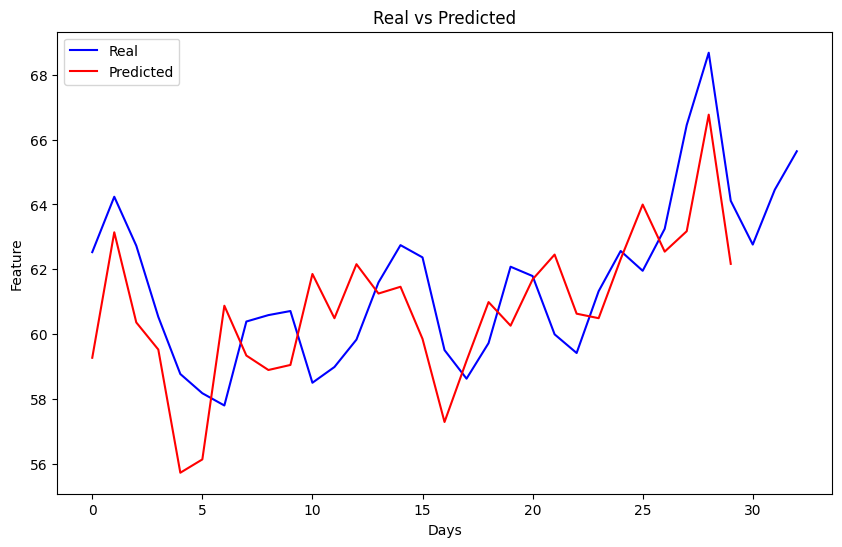

In [78]:
# Random code to visualize stuff
plt.figure(figsize=(10,6))
plt.plot(real_temperature, label='Real', color='blue')
plt.plot(predicted_temperature, label='Predicted', color='red')
plt.title("Real vs Predicted")
plt.xlabel("Days")
plt.ylabel("Feature")
plt.legend()
plt.show()